In [11]:
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

# qqplot
import statsmodels.api as sm
import pylab as py

from scipy.stats import mannwhitneyu,wilcoxon,spearmanr,ttest_ind
from scipy.stats import sem

In [22]:
import sys
sys.path.append('/Users/dbao/Downloads/research/rc_scripts/analysis')

from final_analysis.process_helper.df_choice_add_features import df_choice_add_features
from final_analysis.process_helper.df_map_add_features import df_map_add_features
from final_analysis.process_helper.df_undo_start_end import df_undo_start_end
from final_analysis.process_helper.df_subset_undo import df_subset_undo

import final_analysis.plot_helper.format
from final_analysis.plot_helper.text import text
save_mode = ".pdf"
font_size = 18

In [13]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')
rcompanion = importr('rcompanion')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Load data

In [14]:
home_dir = '/Users/dbao/Library/CloudStorage/GoogleDrive-sherrydbao@gmail.com/.shortcut-targets-by-id/1sYZNVBbYCrHcHjo-9xdKcA4wLnob9ZEq/'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [15]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})

pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning
data_choice_level = df_choice_add_features(data_choice_level)
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

In [16]:
data_puzzle_level = pd.read_csv(data_dir +  'data.csv') # first column is subject
data_puzzle_level = df_map_add_features(data_puzzle_level, data_choice_level)

In [17]:
single_condition_data = data_puzzle_level[data_puzzle_level['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)

# *Puzzle MAS distribution (supp)

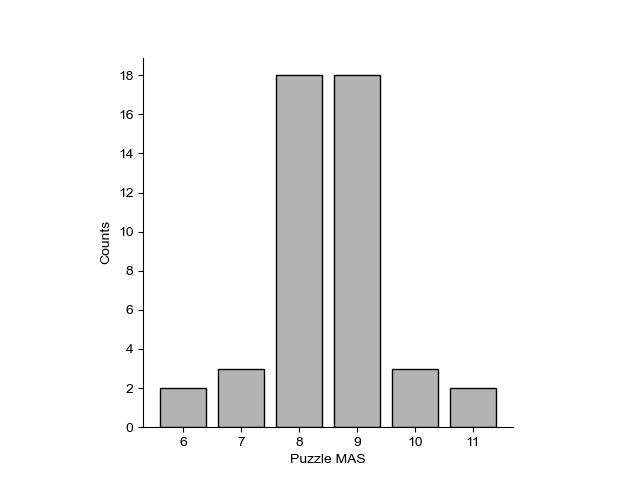

In [8]:
%matplotlib widget

n_mas = single_condition_data[single_condition_data.subjects==2].groupby(['mas'])['mas'].count() # only undo condition

fig, axs = plt.subplots(1, 1)
axs.bar(range(6,12), n_mas,
        color = (.7,.7,.7),
        edgecolor = 'k')## puzzle MAS

### histogram of MAS/remaining budget, numFullUndo',)
axs.set_ylabel('Counts') 
axs.set_yticks(list(range(0, 20, 2)))
axs.set_xlabel('Puzzle MAS')
# change size ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')
#plt.show()
fig.savefig(out_dir + 'count_mas_puzzle.png', dpi=300, bbox_inches='tight')

# *Total RT

In [9]:

# num_city = data_puzzle_level.groupby(['subjects','puzzleID','condition'])['numCities'].mean().groupby(['condition'])
# # print(num_city.describe())
# reward = data_puzzle_level.groupby(['subjects','puzzleID','condition'])['reward'].mean().groupby(['condition'])
# # print(reward.describe())
TT = data_puzzle_level.groupby(['subjects','puzzleID','condition'])['TT'].sum().groupby(['subjects','condition']).mean().groupby(['condition'])
print(TT.mean(), TT.sem())

condition
0    17.305822
1    22.532387
Name: TT, dtype: float64 condition
0    0.588342
1    0.961501
Name: TT, dtype: float64


# *Number of undo

In [18]:
num_undo = single_condition_data.groupby(['subjects','puzzleID'])['numFullUndo'].sum().groupby('subjects').mean()
print(num_undo.mean(), num_undo.sem())

0.5782608695652174 0.06402884176645277


In [19]:
unique_values = np.sort(single_condition_data['numFullUndo'].unique())
# Adjust bins to combine values larger than 4 into one bin
# Find the index of the bin that corresponds to the value 4
index_of_4 = np.searchsorted(unique_values, 4, side='right')
# Adjust bins to include only up to the value of 4 and one additional bin for all values > 4
adjusted_bins = np.concatenate((unique_values[:index_of_4 + 1], [unique_values[-1] + 0.5]))

# Recompute histograms with adjusted bins
subject_histograms = single_condition_data.groupby('subjects')['numFullUndo'].apply(
    lambda x: np.histogram(x, bins=adjusted_bins, density=True)[0]
)
subject_histograms_df = pd.DataFrame(subject_histograms.tolist())

# Since bins have been adjusted, recalculate mean and SEM for the new bins
mean_histogram = subject_histograms_df.mean()
sem_histogram = subject_histograms_df.sem()

# Adjust bin_edges and bin_centers for plotting, if necessary
# Define new bin edges considering the adjustment
adjusted_bin_edges = adjusted_bins
# Calculate new bin centers
adjusted_bin_centers = (adjusted_bin_edges[:-1] + adjusted_bin_edges[1:]) / 2

(single_condition_data['numFullUndo']>5).sum()/len(single_condition_data)

0.010869565217391304

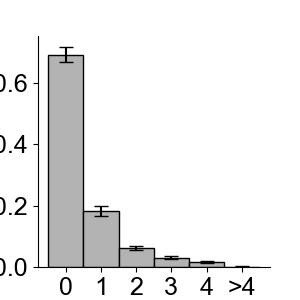

In [23]:
%matplotlib widget
plt.rcParams.update({'font.size': font_size})
# Plotting the histogram
plt.figure(figsize=(3, 3))
plt.bar(range(0,6), mean_histogram, 
        width=(adjusted_bin_edges[1] - adjusted_bin_edges[0]), 
        yerr=sem_histogram, capsize=5, 
        color = (.7,.7,.7), 
        edgecolor = 'k')
# modify xtick labels
plt.xticks(range(0,6), ["0", "1", "2", "3", "4", ">4"])
plt.xlabel('Number of Undo')
plt.ylabel('Proportion')
plt.show()
plt.savefig(out_dir + 'hist_undo' + save_mode, dpi=300, bbox_inches='tight')

# *task difficulty

## rt1 - Map MAS

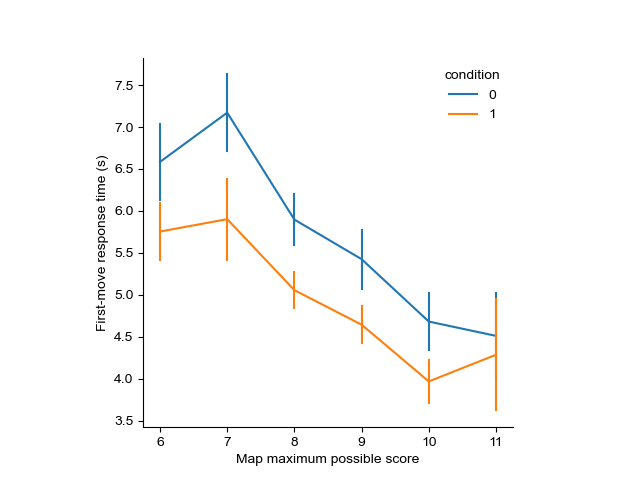

In [ ]:
RT_sub = data_puzzle_level.groupby(['condition','subjects','mas'])['RT1'].mean().reset_index()

fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='mas', y='RT1', 
             data = RT_sub,
             hue = 'condition',
             color = ['k','r'],
             err_style = "bars",
             errorbar = "se")
axs.set(xlabel='Map maximum possible score', ylabel='First-move response time (s)')
axs.set_aspect(1/axs.get_data_ratio())

fig.savefig(out_dir+'rt_allMAS.png', dpi=300, bbox_inches='tight')
plt.show()

## action gap

In [8]:
# bin "action_gap" of puzzleID_order_data, which ranges from 2.5 to 6
temp, cutoff_actiongap = pd.cut(data_puzzle_level['action_gap'], 5 , labels = False, retbins=True)
data_puzzle_level["action_gap_bin"] = temp

In [9]:
# correlation between RT1 for each condition
x1 = data_puzzle_level[data_puzzle_level.condition==1].groupby(['puzzleID'])['RT1'].mean()
x2 = data_puzzle_level[data_puzzle_level.condition==0].groupby(['puzzleID'])['RT1'].mean()
spearmanr(x1,x2)

SpearmanrResult(correlation=0.5728646315140302, pvalue=3.174956286948255e-05)

In [13]:
action_gap = data_puzzle_level[data_puzzle_level.condition==1].groupby(['puzzleID'])['action_gap'].mean()
print(spearmanr(x1, action_gap))
print(spearmanr(x2, action_gap))

SpearmanrResult(correlation=-0.4115216215854192, pvalue=0.004492340940559376)
SpearmanrResult(correlation=-0.5910688998280984, pvalue=1.5255591168665379e-05)


In [15]:
data_puzzle_level.columns


Index(['subjects', 'puzzleID', 'action_gap', 'condition', 'trialID', 'block',
       'reward', 'numCities', 'mas', 'nos', 'leftover', 'numUNDO', 'numEnd',
       'TT', 'RT1', 'RTsubmit', 'numError', 'sumSeverityErrors',
       'final_sumSeverityErrors', 'final_missed_reward', 'final_error_rate',
       'SeverityError1', 'numFullUndo', 'RTlater', 'avg_numCities_before',
       'RT_branching', 'action_gap_bin'],
      dtype='object')

In [16]:
data_puzzle_level['cumulative_error'] = data_puzzle_level.mas - data_puzzle_level.numCities
cumulative_error = data_puzzle_level[data_puzzle_level.condition==0].groupby(['puzzleID'])['cumulative_error'].mean()
print(spearmanr(cumulative_error, action_gap))

SpearmanrResult(correlation=0.4388686694219973, pvalue=0.002280250981185541)


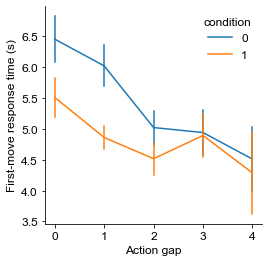

In [ ]:
RT_sub = data_puzzle_level.groupby(['condition','subjects','action_gap_bin'])['RT1'].mean().reset_index()

fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='action_gap_bin', y='RT1', 
             data = RT_sub,
             hue = 'condition',
             color = ['k','r'],
             err_style = "bars",
             errorbar = "se")
axs.set(xlabel='Action gap', ylabel='First-move response time (s)')
axs.set_aspect(1/axs.get_data_ratio())

fig.savefig(out_dir+'rt1_actiongap.png', dpi=300, bbox_inches='tight')
plt.show()

## Number of optimal solutions

In [ ]:
# bin "action_gap" of puzzleID_order_data, which ranges from 2.5 to 6
temp, cutoff_num_optimal = pd.cut(data_puzzle_level['nos'], 5 , labels = False, retbins=True)
data_puzzle_level["num_optimal_bin"] = temp

condition  num_optimal_bin
0          0                  100
           1                  100
           2                  100
           4                  100
1          0                  100
           1                  100
           2                  100
           4                  100
Name: RT1, dtype: int64


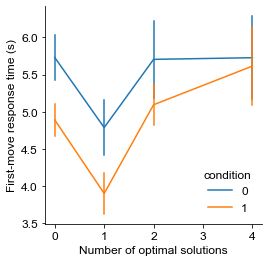

In [ ]:
RT_sub = data_puzzle_level.groupby(['condition','subjects','num_optimal_bin'])['RT1'].mean().reset_index()
print(RT_sub.groupby(['condition','num_optimal_bin'])['RT1'].count())

fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='num_optimal_bin', y='RT1',    
             data = RT_sub,
             hue = 'condition',
             color = ['k','r'],
             err_style = "bars",
             errorbar = "se")
axs.set(xlabel='Number of optimal solutions', ylabel='First-move response time (s)')
axs.set_aspect(1/axs.get_data_ratio())

fig.savefig(out_dir+'rt1_num_optimal.png', dpi=300, bbox_inches='tight')
plt.show()

# move RT

In [13]:
def get_RT_cond(cond,RTtype):
    RT = data_puzzle_level[data_puzzle_level['condition']==cond]
    RT_sub = RT.groupby(['subjects'])[RTtype].mean()
    RT_sub_sem = sem(RT_sub)
    return [RT_sub,RT_sub_sem]

RT1_basic = get_RT_cond(0,'RT1')
RT1_undo = get_RT_cond(1,'RT1')

RTlater_basic = get_RT_cond(0,'RTlater')
RTlater_undo = get_RT_cond(1,'RTlater')

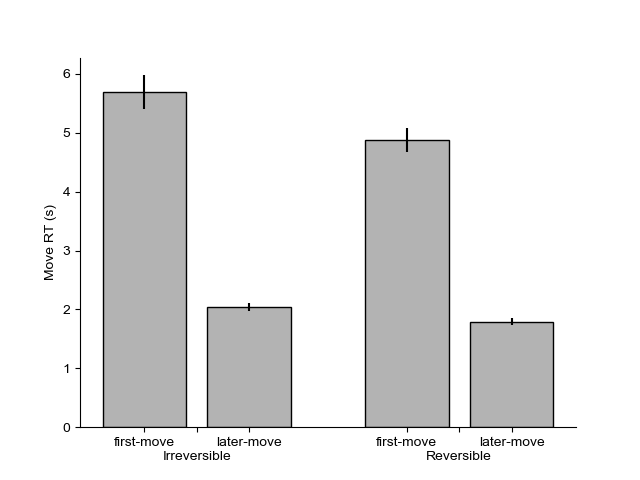

In [14]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.bar([1,2, 3.5,4.5],
             
             [np.mean(RT1_basic[0]), np.mean(RTlater_basic[0]),
              np.mean(RT1_undo[0]), np.mean(RTlater_undo[0])],
             
             color = (.7,.7,.7), 
             edgecolor = 'k',
             
             yerr=[RT1_basic[1], RTlater_basic[1],
                   RT1_undo[1], RTlater_undo[1]])

axs.set_xticks([1,1.5,2, 3.5,4,4.5])
axs.set_xticklabels(labels = ['first-move','\nIrreversible','later-move',
                              'first-move','\nReversible','later-move'])#,fontsize=18
axs.set_ylabel('Move RT (s)')

plt.show()
fig.savefig(out_dir + 'move_RT.pdf', dpi=600, bbox_inches='tight')

In [15]:
# Create a copy explicitly first
test_df = data_choice_level[(data_choice_level.undo==0) & (data_choice_level.RT!=-1)].copy()
# test_df.loc[:, 'first_move'] = (test_df['currNumCities'] == 1)
test_df['log_RT'] = np.log(test_df['RT']/1000+1)

In [16]:
%%R -i test_df

test_df$first_move = as.factor(test_df$first_move)
test_df$condition = as.factor(test_df$condition)
test_df$subjects = as.factor(test_df$subjects)
test_df$puzzleID = as.factor(test_df$puzzleID)

# For later move
# test_df$first_move = relevel(test_df$first_move, ref="FALSE")
model_rt = lme4::glmer(log_RT ~  1 + condition  + (1 |subjects) + (1|puzzleID),
                       data = test_df[test_df$first_move=="TRUE",])
print(summary(model_rt))

Linear mixed model fit by REML ['lmerMod']
Formula: log_RT ~ 1 + condition + (1 | subjects) + (1 | puzzleID)
   Data: test_df[test_df$first_move == "TRUE", ]

REML criterion at convergence: 11218.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1801 -0.6479 -0.1302  0.5172  8.5831 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.08023  0.2832  
 puzzleID (Intercept) 0.01197  0.1094  
 Residual             0.18775  0.4333  
Number of obs: 9200, groups:  subjects, 100; puzzleID, 46

Fixed effects:
             Estimate Std. Error t value
(Intercept)  1.694784   0.033215  51.025
condition1  -0.080268   0.009035  -8.884

Correlation of Fixed Effects:
           (Intr)
condition1 -0.136


In [18]:
%%R

# For first move
test_df$first_move = relevel(test_df$first_move, ref="FALSE") 
model_rt = lme4::glmer(log_RT ~  1 + first_move+condition  + (1 |subjects) + (1|puzzleID),
                       data = test_df)
print(summary(model_rt))    

Linear mixed model fit by REML ['lmerMod']
Formula: log_RT ~ 1 + first_move + condition + (1 | subjects) + (1 | puzzleID)
   Data: test_df

REML criterion at convergence: 66522.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4299 -0.6014 -0.2285  0.3494 15.0065 

Random effects:
 Groups   Name        Variance  Std.Dev.
 subjects (Intercept) 0.0260909 0.16153 
 puzzleID (Intercept) 0.0006069 0.02464 
 Residual             0.1203486 0.34691 
Number of obs: 91412, groups:  subjects, 100; puzzleID, 46

Fixed effects:
                Estimate Std. Error t value
(Intercept)     0.845345   0.016655   50.76
first_moveTRUE  0.822037   0.003825  214.90
condition1     -0.025465   0.002339  -10.89

Correlation of Fixed Effects:
            (Intr) f_TRUE
frst_mvTRUE -0.027       
condition1  -0.079  0.040
